# 1. First fetching the meterological data from meteostat

In [111]:
from datetime import datetime
from meteostat import Point, Daily
import pandas as pd

# Location: Kathmandu
kathmandu = Point(27.7172, 85.3240, 1400)

# Date range: past 6 months
start = datetime(2024, 3, 1)
end = datetime(2025, 2, 28)

# Fetch daily weather data
meteo_data = Daily(kathmandu, start, end)
meteo_data = meteo_data.fetch()

# Reset index and keep only available features
meteo_data.reset_index(inplace=True)

# Taking only the relevant columns
meteo_data = meteo_data[['time', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres']]

meteo_data

,time,tavg,tmin,tmax,prcp,wspd,pres
0,2024-03-01,14.4,8.6,21.6,0.0,8.3,1019.3
1,2024-03-02,16.4,12.6,21.6,0.7,7.8,1019.4
2,2024-03-03,14.1,11.6,17.6,13.1,6.0,1018.4
3,2024-03-04,14.6,9.6,21.6,0.1,7.1,1017.8
4,2024-03-05,15.1,8.6,22.6,0.0,8.5,1017.5
...,...,...,...,...,...,...,...
360,2025-02-24,13.8,8.0,20.3,0.0,8.0,1021.7
361,2025-02-25,14.0,8.2,21.2,0.0,7.9,1023.0
362,2025-02-26,15.0,8.6,21.6,0.0,7.4,1023.1
363,2025-02-27,15.0,9.8,21.9,0.0,7.1,1020.5


# Hence the different meterological factors we get info on, are:

**time: Timestamp -> (YYYY-MM-DD (or datetime))**

**tavg: Average Temperature -> (°C (°F))**

**tmin: Minimum Temperature -> (°C (°F))**

**tmax: Maximum Temperature -> (°C (°F))**

**prcp: Precipitation -> (mm (inches))**

**wspd: Wind Speed -> (km/h (or m/s))**

**pres: Air Pressure -> (hPa (or mb))**

# Let's save the data to a csv file

In [112]:
meteo_data.to_csv('meterological_data_fetch.csv', index = False)

# 2. Now getting pm2.5 data from Open-Meteo API

**The Open-Meteo API initially gives hourly data of PM2.5**

In [113]:
import requests

url = "https://air-quality-api.open-meteo.com/v1/air-quality"
params = {
    "latitude": 27.7172,      # Kathmandu coordinates
    "longitude": 85.3240,
    "hourly": "pm2_5",        # Request PM2.5
    "timezone": "auto",       # Automatically adjust timezone
    "start_date": "2024-03-01",
    "end_date": "2025-02-28"  
}

response = requests.get(url, params=params).json()
hourly_data = pd.DataFrame(response["hourly"])
hourly_data

,time,pm2_5
0,2024-03-01T00:00,33.6
1,2024-03-01T01:00,32.1
2,2024-03-01T02:00,31.0
3,2024-03-01T03:00,30.3
4,2024-03-01T04:00,30.2
...,...,...
8755,2025-02-28T19:00,43.0
8756,2025-02-28T20:00,44.2
8757,2025-02-28T21:00,43.8
8758,2025-02-28T22:00,41.3


**Convert it to daily value by giving it the average PM2.5 that day**

In [114]:
# Convert 'time' to datetime and set as index
hourly_data['time'] = pd.to_datetime(hourly_data['time'])
hourly_data.set_index('time', inplace=True)

# Resample to daily mean (or max/min)
daily_data_pm25 = hourly_data.resample('D').mean()  # Change to .max() or .min() if needed
daily_data_pm25.reset_index(inplace=True)           # Reset index to get 'time' as a column
daily_data_pm25

,time,pm2_5
0,2024-03-01,30.054167
1,2024-03-02,33.891667
2,2024-03-03,26.750000
3,2024-03-04,18.020833
4,2024-03-05,12.408333
...,...,...
360,2025-02-24,67.991667
361,2025-02-25,63.891667
362,2025-02-26,61.850000
363,2025-02-27,70.783333


# Let's save the data to csv file

In [115]:
daily_data_pm25.to_csv('pm25_data_fetch.csv', index = False)

# 3. Now combining the two dataframes(Meterological and PM2.5)

In [116]:
main_df = meteo_data.join(daily_data_pm25[['pm2_5']])
main_df = main_df.dropna(subset=['prcp'])
main_df

,time,tavg,tmin,tmax,prcp,wspd,pres,pm2_5
0,2024-03-01,14.4,8.6,21.6,0.0,8.3,1019.3,30.054167
1,2024-03-02,16.4,12.6,21.6,0.7,7.8,1019.4,33.891667
2,2024-03-03,14.1,11.6,17.6,13.1,6.0,1018.4,26.750000
3,2024-03-04,14.6,9.6,21.6,0.1,7.1,1017.8,18.020833
4,2024-03-05,15.1,8.6,22.6,0.0,8.5,1017.5,12.408333
...,...,...,...,...,...,...,...,...
360,2025-02-24,13.8,8.0,20.3,0.0,8.0,1021.7,67.991667
361,2025-02-25,14.0,8.2,21.2,0.0,7.9,1023.0,63.891667
362,2025-02-26,15.0,8.6,21.6,0.0,7.4,1023.1,61.850000
363,2025-02-27,15.0,9.8,21.9,0.0,7.1,1020.5,70.783333


# Again saving it as a csv file 

In [117]:
main_df.to_csv('main_data_table.csv', index = False)

# 4. Finally applying different ML models and evalating them

# 4.1 Linear Regression

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering: create useful features
main_df['date'] = pd.to_datetime(main_df['time'])
main_df['month'] = main_df['date'].dt.month
main_df['dayofweek'] = main_df['date'].dt.dayofweek

# Make sure data is sorted by date (IMPORTANT)
main_df = main_df.sort_values('date')

# Create lag features

for i in range(1, 8):  # 1 to 7 days
    main_df[f'pm2_5_lag{i}'] = main_df['pm2_5'].shift(i)

# Drop rows with NaN values caused by lagging
main_df = main_df.dropna().reset_index(drop=True)

# Drop the time/date column after extraction
X = main_df.drop(columns=['time', 'date', 'pm2_5'])  # Features
y = main_df['pm2_5']  # Target

main_df

,time,tavg,tmin,tmax,prcp,wspd,pres,pm2_5,date,month,dayofweek,pm2_5_lag1,pm2_5_lag2,pm2_5_lag3,pm2_5_lag4,pm2_5_lag5,pm2_5_lag6,pm2_5_lag7
0,2024-03-08,15.1,8.6,22.6,0.0,8.3,1017.0,16.041667,2024-03-08,3,4,15.654167,13.791667,12.408333,18.020833,26.750000,33.891667,30.054167
1,2024-03-09,15.4,9.6,22.6,0.0,9.5,1017.4,18.420833,2024-03-09,3,5,16.041667,15.654167,13.791667,12.408333,18.020833,26.750000,33.891667
2,2024-03-10,15.4,9.6,22.6,0.0,8.9,1019.6,24.900000,2024-03-10,3,6,18.420833,16.041667,15.654167,13.791667,12.408333,18.020833,26.750000
3,2024-03-11,16.9,11.6,23.6,0.0,7.6,1020.1,34.983333,2024-03-11,3,0,24.900000,18.420833,16.041667,15.654167,13.791667,12.408333,18.020833
4,2024-03-12,17.4,10.6,24.6,0.0,8.4,1017.4,26.795833,2024-03-12,3,1,34.983333,24.900000,18.420833,16.041667,15.654167,13.791667,12.408333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,2025-02-24,13.8,8.0,20.3,0.0,8.0,1021.7,67.991667,2025-02-24,2,0,55.000000,39.404167,63.250000,73.775000,76.616667,79.641667,78.583333
350,2025-02-25,14.0,8.2,21.2,0.0,7.9,1023.0,63.891667,2025-02-25,2,1,67.991667,55.000000,39.404167,63.250000,73.775000,76.616667,79.641667
351,2025-02-26,15.0,8.6,21.6,0.0,7.4,1023.1,61.850000,2025-02-26,2,2,63.891667,67.991667,55.000000,39.404167,63.250000,73.775000,76.616667
352,2025-02-27,15.0,9.8,21.9,0.0,7.1,1020.5,70.783333,2025-02-27,2,3,61.850000,63.891667,67.991667,55.000000,39.404167,63.250000,73.775000


In [119]:
# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Linear Regression Model

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [120]:
# Predict and Evaluate

y_pred = model.predict(X_test)

# Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Results:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.2f}")

Linear Regression Results:
MAE  = 4.85
RMSE = 6.89
R²   = 0.90


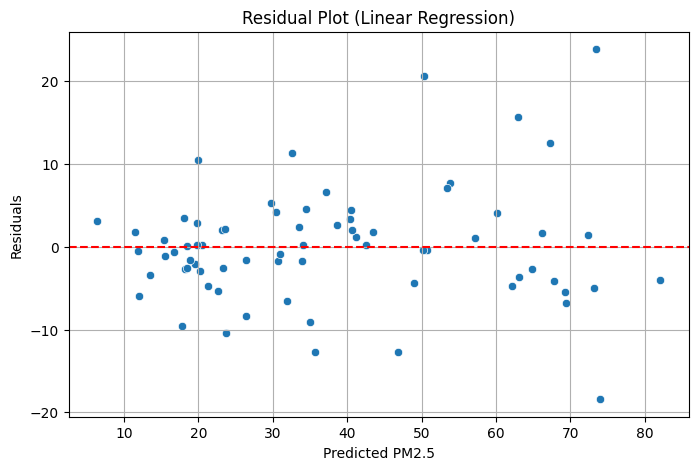

In [121]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted PM2.5')
plt.ylabel('Residuals')
plt.title('Residual Plot (Linear Regression)')
plt.grid(True)
plt.show()


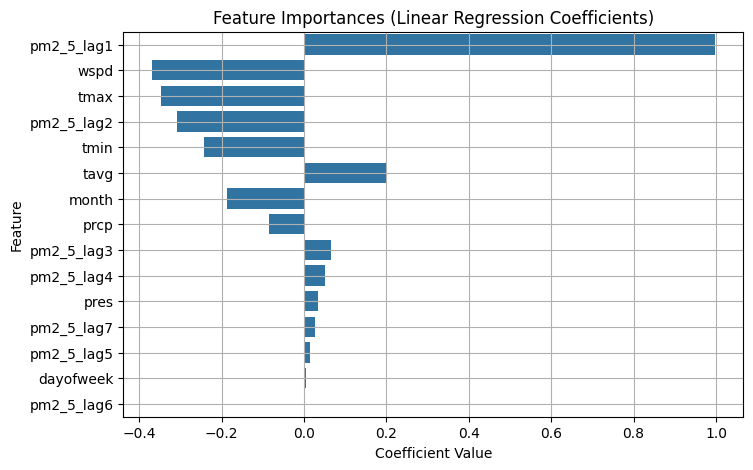

In [122]:
coeffs = pd.Series(model.coef_, index=X.columns)
coeffs = coeffs.sort_values(key=abs, ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=coeffs.values, y=coeffs.index)
plt.title("Feature Importances (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


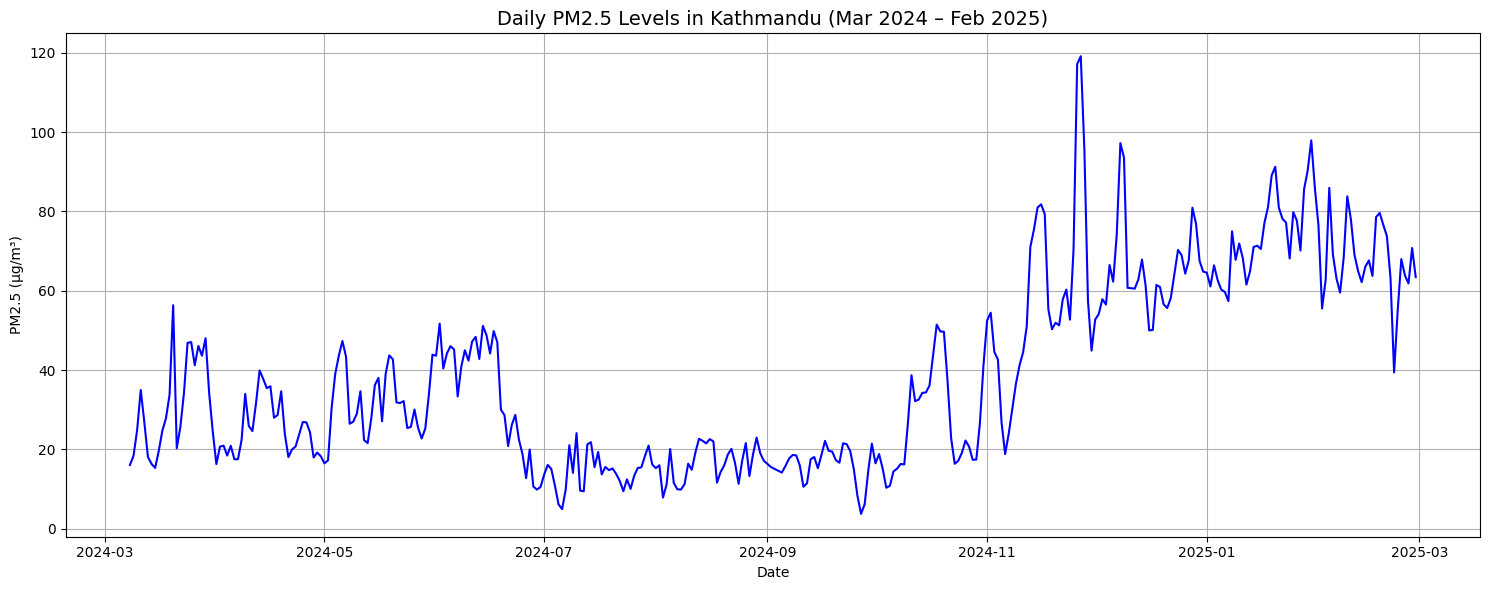

In [123]:
# Make sure your 'date' column is datetime
main_df['date'] = pd.to_datetime(main_df['time'])

# Sort by date just in case
main_df = main_df.sort_values('date')

# Plot
plt.figure(figsize=(15, 6))
sns.lineplot(data=main_df, x='date', y='pm2_5', color='blue')
plt.title('Daily PM2.5 Levels in Kathmandu (Mar 2024 – Feb 2025)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()


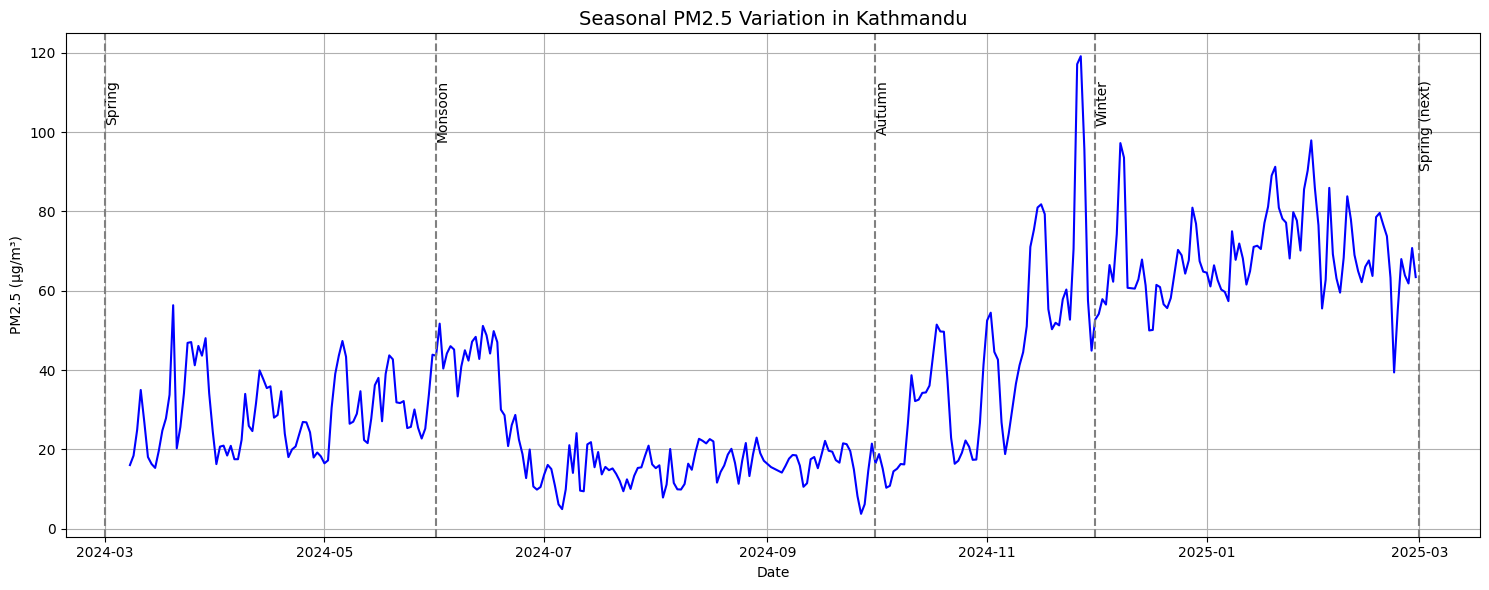

In [124]:
# Define seasonal boundaries
seasons = {
    "Spring": "2024-03-01",
    "Monsoon": "2024-06-01",
    "Autumn": "2024-10-01",
    "Winter": "2024-12-01",
    "Spring (next)": "2025-03-01"
}

# Add to plot
plt.figure(figsize=(15, 6))
sns.lineplot(data=main_df, x='date', y='pm2_5', color='blue')
for label, date in seasons.items():
    plt.axvline(pd.to_datetime(date), color='gray', linestyle='--')
    plt.text(pd.to_datetime(date), main_df['pm2_5'].max() * 0.95, label, rotation=90, verticalalignment='top')

plt.title('Seasonal PM2.5 Variation in Kathmandu', fontsize=14)
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()


# 4.2 Random Forest

In [125]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [126]:
y_pred_rf = rf_model.predict(X_test)

# Metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Results:")
print(f"MAE  = {mae_rf:.2f}")
print(f"RMSE = {rmse_rf:.2f}")
print(f"R²   = {r2_rf:.2f}")

Random Forest Results:
MAE  = 4.78
RMSE = 6.58
R²   = 0.91


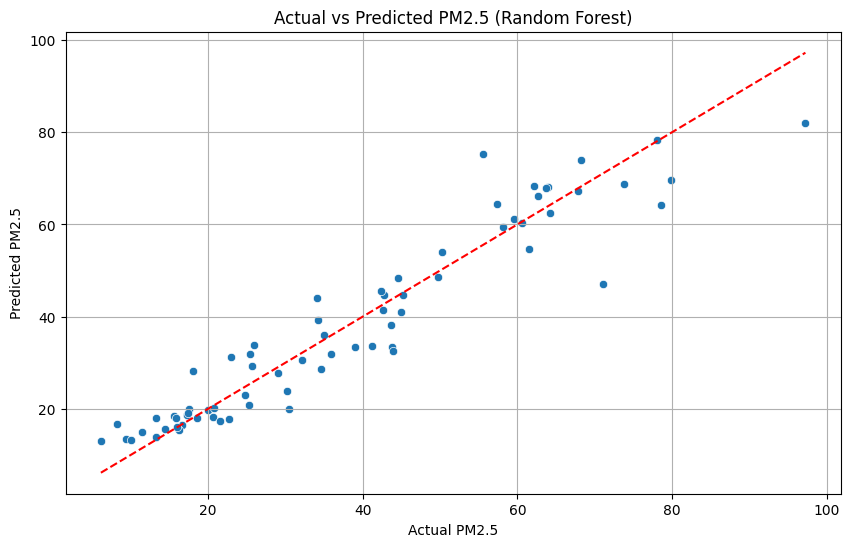

In [127]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5 (Random Forest)')
plt.grid(True)
plt.show()

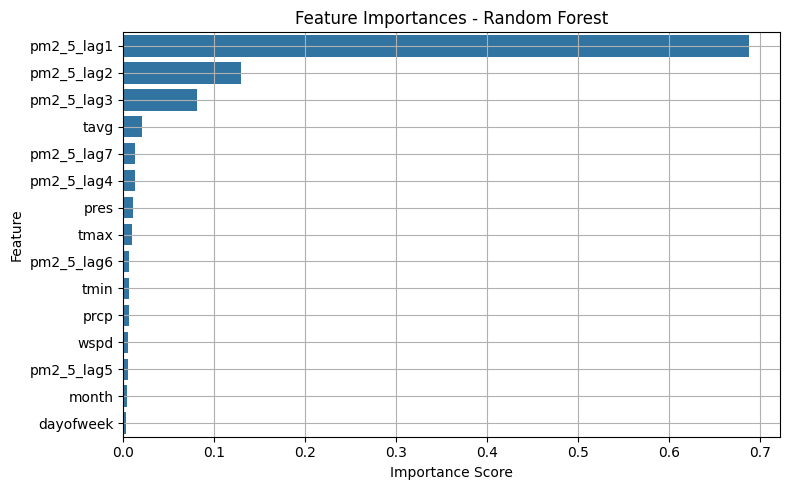

In [128]:
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'PM2.5 Distribution by Month')

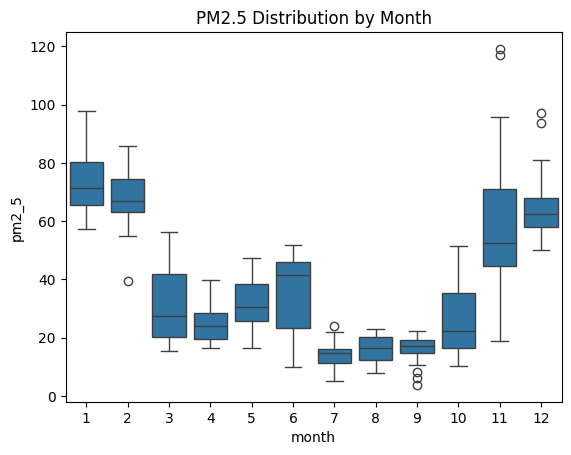

In [129]:
main_df['month'] = pd.to_datetime(main_df['time']).dt.month
sns.boxplot(data=main_df, x='month', y='pm2_5')
plt.title("PM2.5 Distribution by Month")


In [130]:
def season_from_month(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Autumn'

main_df['season'] = pd.to_datetime(main_df['time']).dt.month.map(season_from_month)


Text(0.5, 1.0, 'PM2.5 by Season')

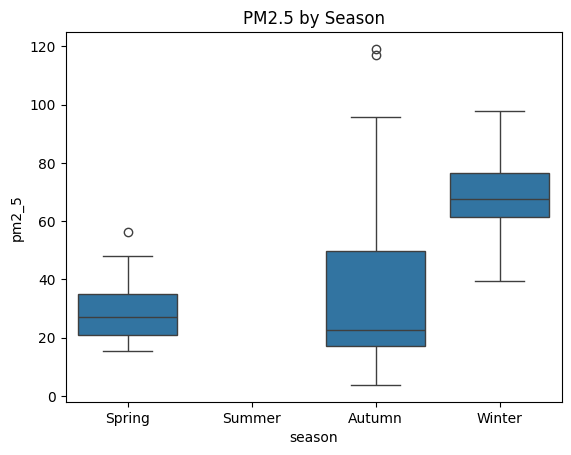

In [131]:
sns.boxplot(data=main_df, x='season', y='pm2_5', order=['Spring', 'Summer', 'Autumn', 'Winter'])
plt.title("PM2.5 by Season")


# 4.3 XGBoost

In [132]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

In [133]:
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Results:")
print(f"MAE  = {mae_xgb:.2f}")
print(f"RMSE = {rmse_xgb:.2f}")
print(f"R²   = {r2_xgb:.2f}")


XGBoost Results:
MAE  = 5.10
RMSE = 6.79
R²   = 0.90


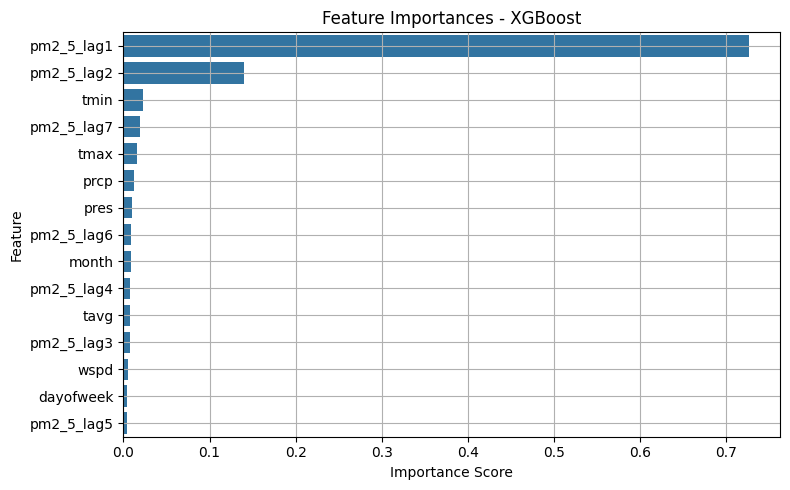

In [134]:
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
xgb_importance = xgb_importance.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=xgb_importance.values, y=xgb_importance.index)
plt.title("Feature Importances - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()
